Using device: cuda
Epoch 1/50: train_loss=0.2432, train_acc=92.17%, test_loss=0.0914, test_acc=96.56%
Epoch 2/50: train_loss=0.1483, train_acc=94.97%, test_loss=0.0635, test_acc=98.00%
Epoch 3/50: train_loss=0.1275, train_acc=95.94%, test_loss=0.0510, test_acc=98.00%
Epoch 4/50: train_loss=0.1037, train_acc=96.17%, test_loss=0.0510, test_acc=98.33%
Epoch 5/50: train_loss=0.0767, train_acc=97.31%, test_loss=0.0374, test_acc=98.56%
Epoch 6/50: train_loss=0.0851, train_acc=97.11%, test_loss=0.0357, test_acc=98.89%
Epoch 7/50: train_loss=0.0911, train_acc=97.11%, test_loss=0.0532, test_acc=98.22%
Epoch 8/50: train_loss=0.0602, train_acc=97.81%, test_loss=0.0324, test_acc=99.00%
Epoch 9/50: train_loss=0.0718, train_acc=97.36%, test_loss=0.0226, test_acc=99.56%
Epoch 10/50: train_loss=0.0540, train_acc=98.17%, test_loss=0.0166, test_acc=99.44%
Epoch 11/50: train_loss=0.0720, train_acc=97.56%, test_loss=0.0248, test_acc=99.56%
Epoch 12/50: train_loss=0.0576, train_acc=98.22%, test_loss=0.0323

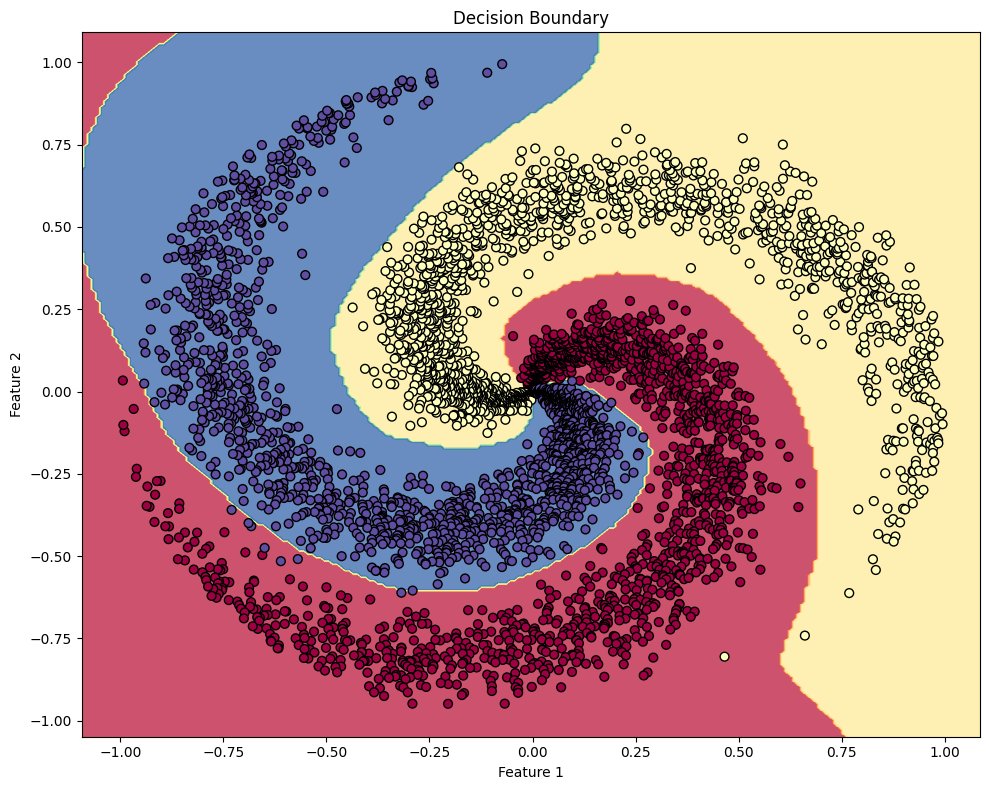

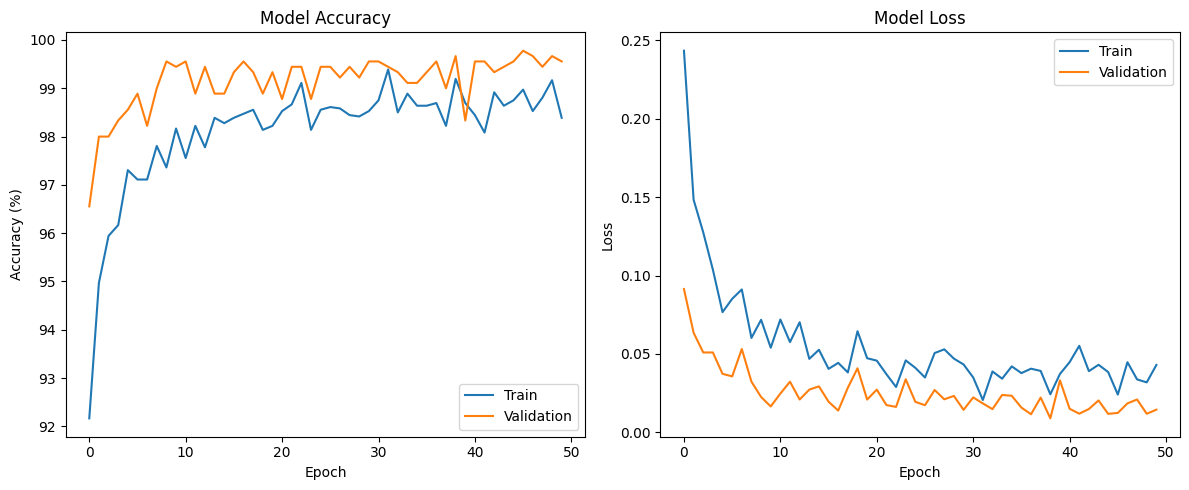

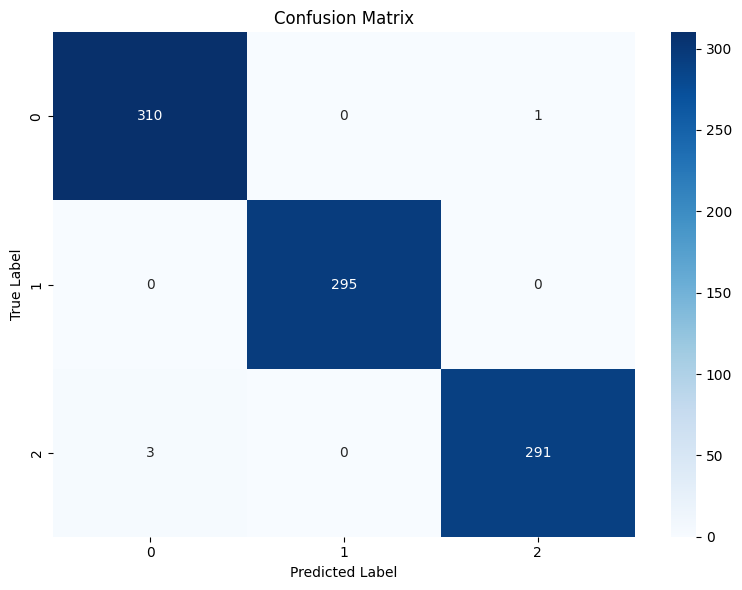

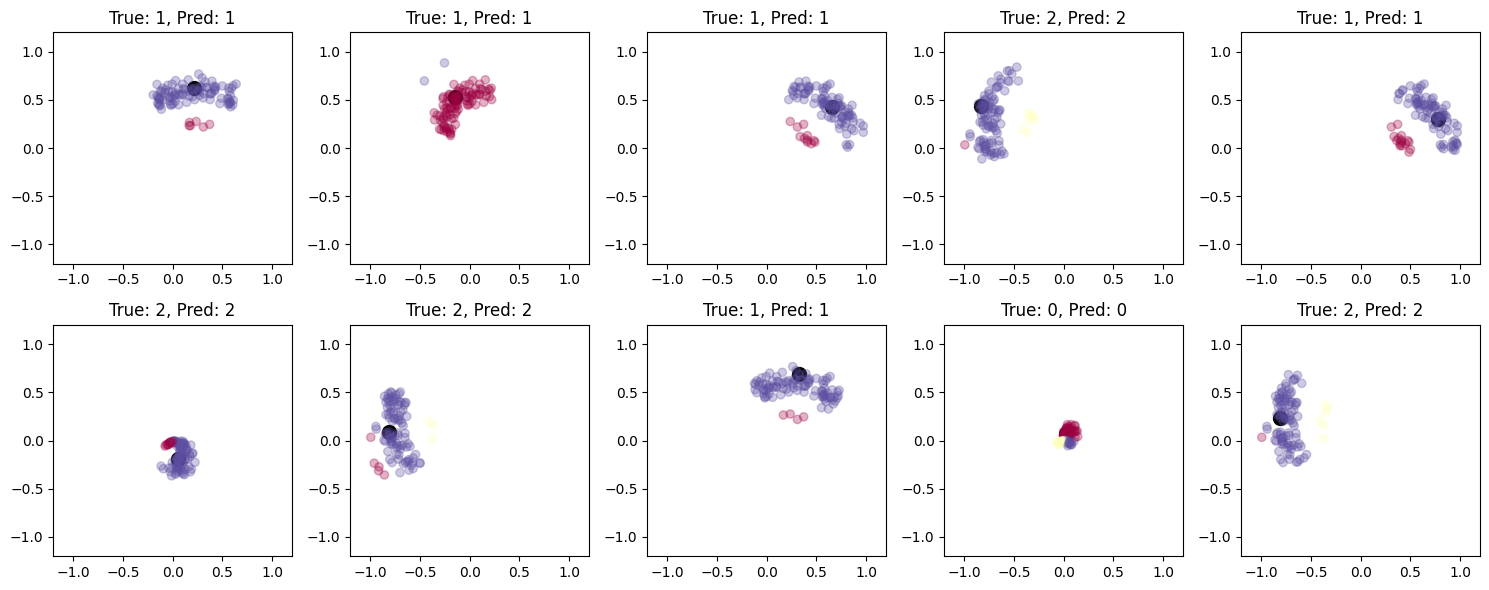

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       311
           1       1.00      1.00      1.00       295
           2       1.00      0.99      0.99       294

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900



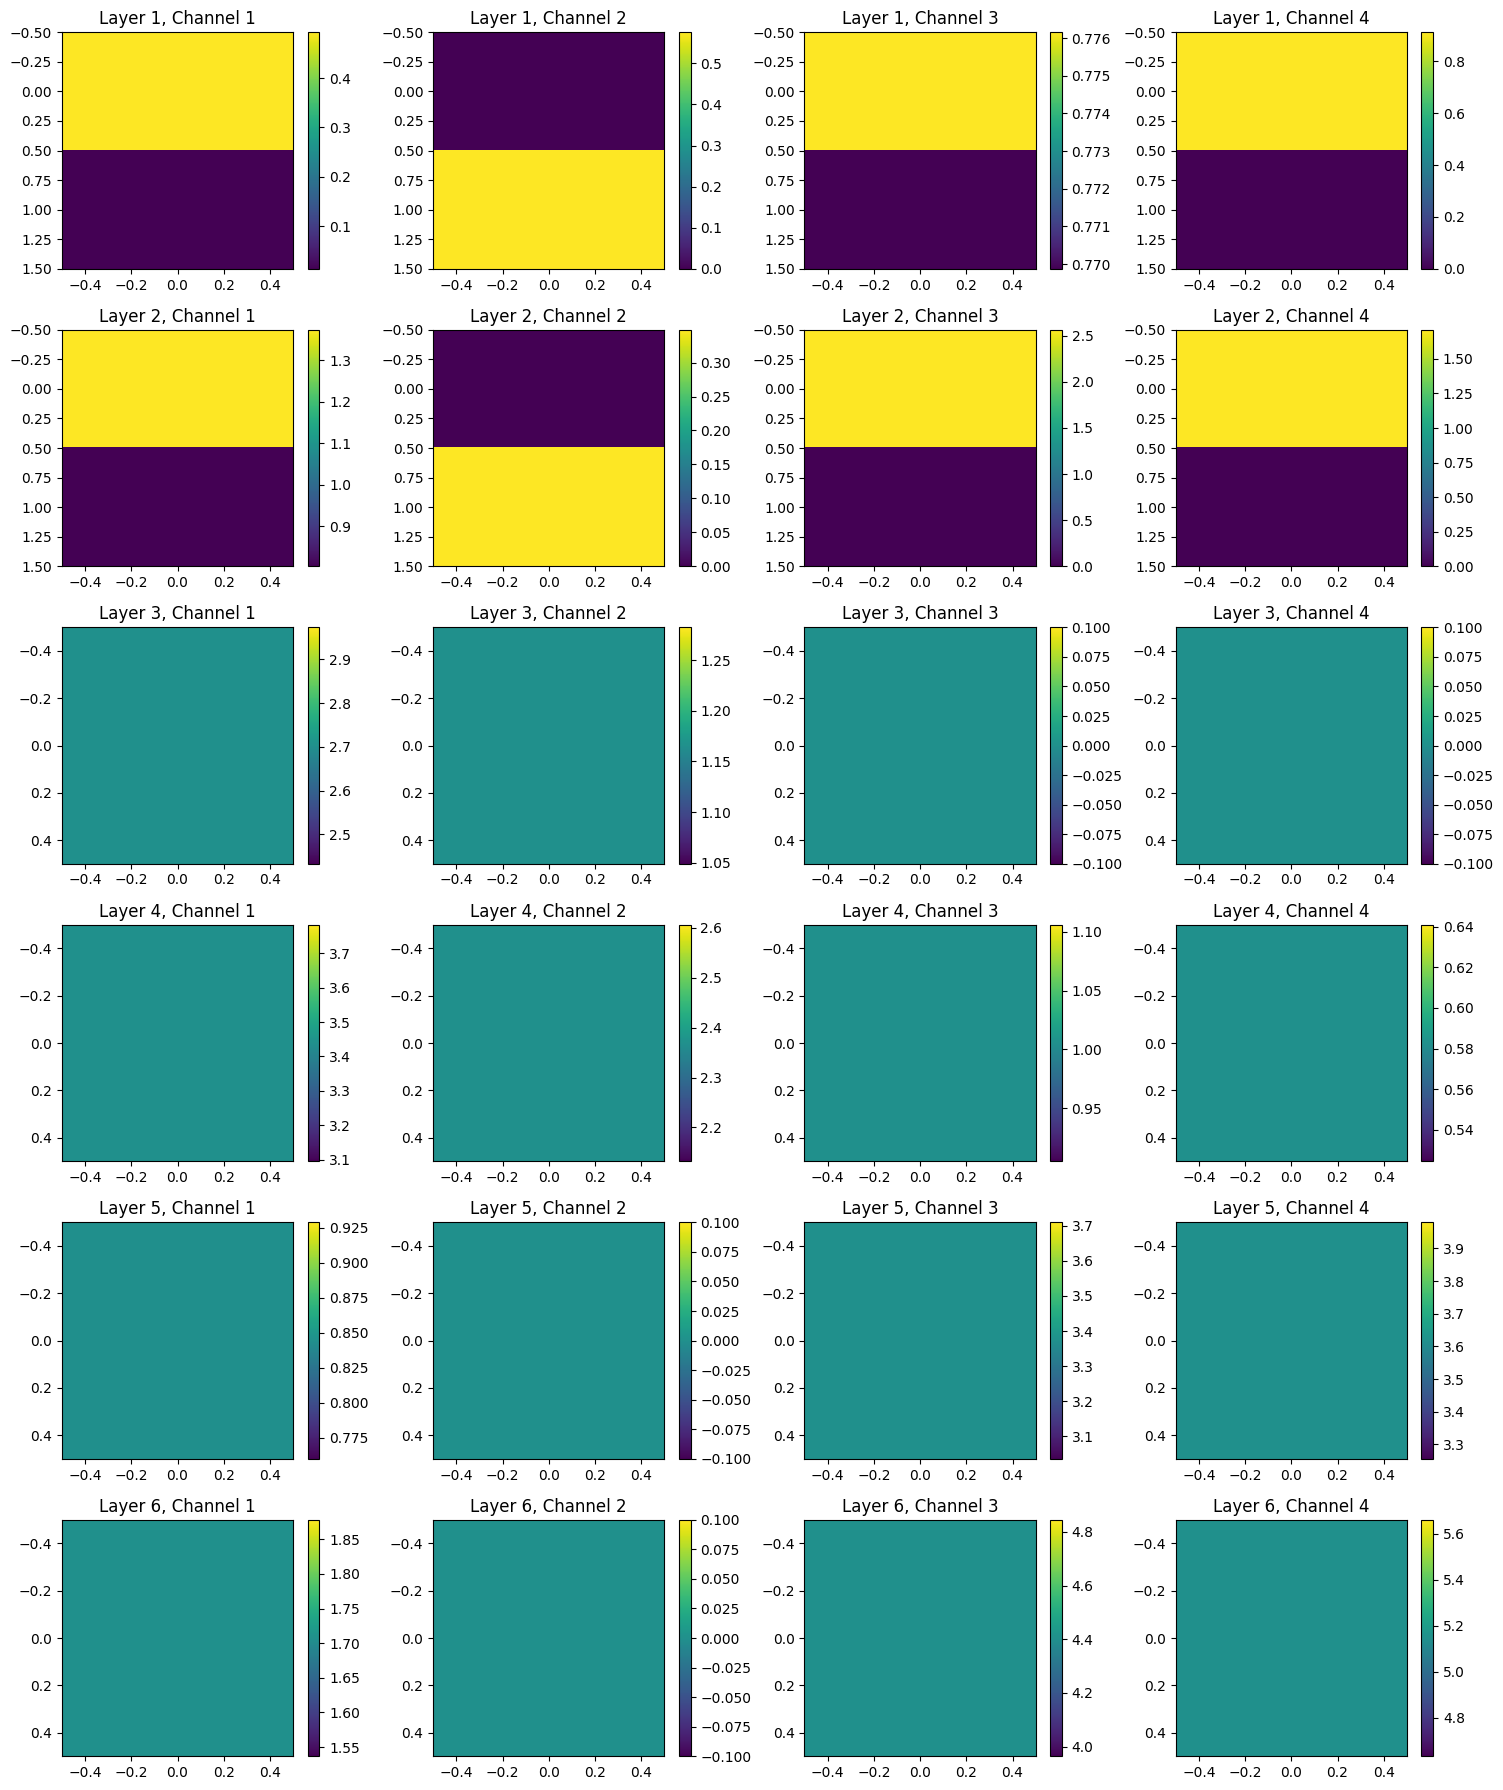

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Generate a synthetic dataset
def generate_spiral_data(samples_per_class=1000, classes=3, noise=0.2):
    X = np.zeros((samples_per_class * classes, 2))
    y = np.zeros(samples_per_class * classes, dtype='int64')
    
    for class_idx in range(classes):
        ix = range(samples_per_class * class_idx, samples_per_class * (class_idx + 1))
        r = np.linspace(0.0, 1, samples_per_class)  # radius
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, samples_per_class) + np.random.randn(samples_per_class) * noise  # theta
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_idx
    
    return X, y

# Generate the dataset
X, y = generate_spiral_data(samples_per_class=1500, classes=3, noise=0.3)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create dataset and dataloader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)
        out = self.relu(out)
        
        return out

# 3. Build a simple ResNet model
class ResNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ResNet, self).__init__()
        
        # Initial layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # Residual blocks
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 32),
            ResidualBlock(32, 32)
        )
        
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2),
            ResidualBlock(64, 64)
        )
        
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128)
        )
        
        # Global Average Pooling and classification layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        # Reshape input data to have channel dimension
        # Input is (batch_size, 2)
        x = x.view(-1, 1, 2, 1)  # (batch_size, channels, height, width)
        
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global average pooling and classification
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x

# Initialize the model
model = ResNet(num_classes=3).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    
    return train_loss, train_acc

# 5. Evaluation function
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    
    return test_loss, test_acc, all_preds, all_targets

# 6. Train the model
epochs = 50
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc, _, _ = evaluate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch+1}/{epochs}: train_loss={train_loss:.4f}, train_acc={train_acc:.2f}%, test_loss={test_loss:.4f}, test_acc={test_acc:.2f}%')

# 7. Final evaluation
_, _, all_preds, all_targets = evaluate(model, test_loader, criterion, device)

# 8. Visualizations
# Decision boundary visualization
def plot_decision_boundary(X, y, model, device):
    h = 0.01  # Step size
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Create tensors from meshgrid
    grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        Z = model(grid_tensor)
        Z = torch.argmax(Z, dim=1).cpu().numpy()
    
    # Reshape back to meshgrid dimensions
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k', s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.tight_layout()
    plt.savefig('decision_boundary_pytorch.png')
    plt.show()

# Plot training history
def plot_training_history(train_losses, train_accs, test_losses, test_accs):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accs)
    plt.plot(test_accs)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_losses)
    plt.plot(test_losses)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_history_pytorch.png')
    plt.show()

# Confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_pytorch.png')
    plt.show()

# Custom visualization showing individual examples
def plot_sample_predictions(X, y_true, y_pred, num_samples=10):
    # Randomly select examples
    indices = np.random.choice(range(len(X)), size=num_samples, replace=False)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.scatter(X[idx, 0], X[idx, 1], c='black', s=100, marker='o')
        
        # Plot nearby points for context
        dist = np.sum((X - X[idx])**2, axis=1)
        nearest_indices = np.argsort(dist)[:100]
        plt.scatter(X[nearest_indices, 0], X[nearest_indices, 1], 
                   c=y_true[nearest_indices], cmap=plt.cm.Spectral, alpha=0.3)
        
        plt.title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
        plt.xlim(-1.2, 1.2)
        plt.ylim(-1.2, 1.2)
    
    plt.tight_layout()
    plt.savefig('sample_predictions_pytorch.png')
    plt.show()

# 9. Generate all visualizations
# Convert tensors back to numpy for visualization
model.to('cpu')  # Move model back to CPU for simple inference

# Decision boundary
plot_decision_boundary(X, y, model, 'cpu')

# Training history
plot_training_history(train_losses, train_accs, test_losses, test_accs)

# Confusion matrix
plot_confusion_matrix(all_targets, all_preds)

# Sample predictions
plot_sample_predictions(X_test, y_test, all_preds)

# Print classification report
print("Classification Report:")
print(classification_report(all_targets, all_preds))

# 10. Visualizing feature maps (bonus)
def plot_feature_maps(model, input_sample):
    # Get a single input sample and add batch dimension
    sample = torch.FloatTensor(input_sample).unsqueeze(0)
    
    # Define hooks to capture feature maps
    feature_maps = []
    
    def hook_fn(module, input, output):
        feature_maps.append(output.detach().cpu())
    
    # Register hooks for all residual blocks
    hooks = []
    for name, module in model.named_modules():
        if isinstance(module, ResidualBlock):
            hooks.append(module.register_forward_hook(hook_fn))
    
    # Forward pass to get feature maps
    with torch.no_grad():
        model(sample)
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    # Plot feature maps
    num_layers = len(feature_maps)
    plt.figure(figsize=(15, num_layers * 3))
    
    for i, fmap in enumerate(feature_maps):
        # Get feature map from batch (index 0)
        # Shape is [batch, channels, height, width]
        fmap = fmap[0]  # Get the first batch
        num_channels = min(4, fmap.shape[0])
        
        for j in range(num_channels):
            plt.subplot(num_layers, num_channels, i * num_channels + j + 1)
            
            # Create a heatmap rather than trying to display the actual feature map
            # This works even when the feature map shape isn't a proper 2D image
            channel_data = fmap[j].numpy()
            if len(channel_data.shape) == 1:
                # For 1D data, create a row vector visualization
                channel_data = channel_data.reshape(1, -1)
            elif len(channel_data.shape) > 2:
                # For higher dimensional data, flatten to 2D by taking mean across extra dimensions
                channel_data = np.mean(channel_data, axis=tuple(range(2, len(channel_data.shape))))
            
            plt.imshow(channel_data, cmap='viridis', aspect='auto')
            plt.title(f"Layer {i+1}, Channel {j+1}")
            plt.colorbar()
            plt.axis('on')  # Show axes to understand the dimensions
    
    plt.tight_layout()
    plt.savefig('feature_maps_pytorch.png')
    plt.show()

# Get a sample from each class
samples_per_class = []
for class_idx in range(3):
    class_samples = X_test[y_test == class_idx]
    if len(class_samples) > 0:
        samples_per_class.append(class_samples[0])

# Plot feature maps for one sample
if samples_per_class:
    plot_feature_maps(model, samples_per_class[0])